**TODO**:
<br/>. implied vol example
<br/>. get spot from html `postMarketPrice`
<br/>. get market time from `postMarketTime`
<br/>. use both for vol smile and vol surface data input

Displaying the volatility smile and the volatility surface for selected tickers with NYSE data from Yahoo Finance.

# Implied volatility: Example

# Volatility smile


## Related definitions for this topic

### Moneyness of an option

In the money: with the current spot price of the underlying the option will pay

Out of the money: $\,S_0<K\,$ for call and $\,S_0>K\,$ for put.

At the money (ATM): $\,S_0=K\,$.

### Over the counter (OTC)

Contracts are usually made
* either `at exchanges` through marketmakers, with fixed conditions and reduced risk,
* or directly between two sides, that is, `OTC` (over-the-counter), with tailored conditions and higher risk.

### Open interest

For a standardized contract type, this is the number of currently active contracts of this type.

## Observe and Download the data

1. Go to Yahoo Finance > Microsoft > Options at
<br/>https://finance.yahoo.com/quote/MSFT/options


2. Read (with your eyes) the spot price from the html page and write it into PAR['spot'] at the top of the code below.


3. Observe that each row displays information about one standardized contract type.


4. Above the top left of the "Calls" table there is a date dropdown.
<br/>Select the date that is **closest to your current date**.
<br/>This means you're downloading information on options for **short maturities**.


5. Download the webpage as a single html to the `data` subfolder of your current folder.
<br/>
The name of the downloaded file is "Microsoft Corporation (MSFT) Options Chain - Yahoo Finance.html".


## Implied volatility and Open interest

Process the downloaded html file with the code below.


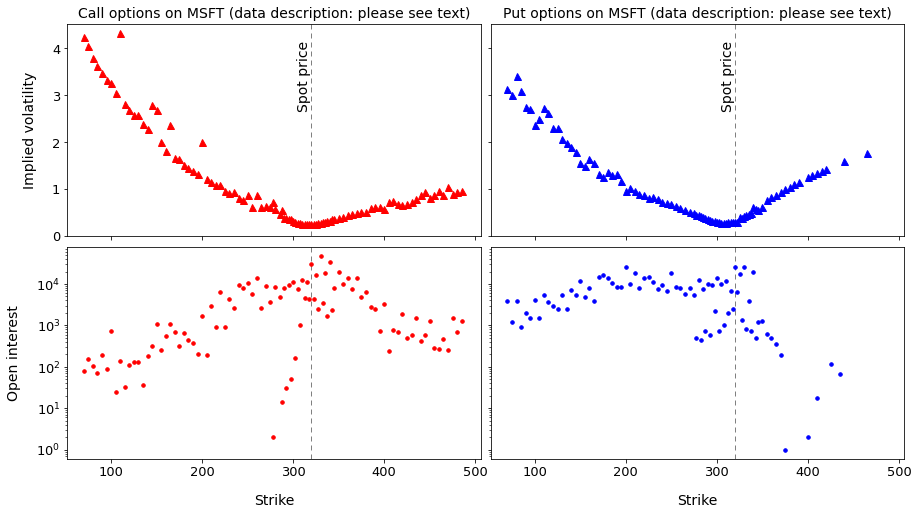

In [29]:
from os.path import join
import re
from collections import OrderedDict
from glob import glob
from matplotlib import pyplot as plt

PAR = {
    'spot': 320.10,  # write the spot price here
    'data_dir': 'data',
    'stock_ticker': 'MSFT',
    'data_file_name': 'Microsoft Corporation (MSFT) Options Chain - Yahoo Finance.html',
    'figure_size': (15, 8),
    'option_types': ['call', 'put'],
    'color_list': ['red', 'blue'],
    'fontsize': 14,
    'label_pad': 15,
    'ticks_fontsize': 13,
    'subplots_width_space': 0.025,
    'subplots_height_space': 0.05,
    'spot_color': 'gray',
    'spot_line_width': 1,
    'spot_dash_length': (5, 4)
}


def read_options_data(par=None):
    """
    Read and process options data from a html file saved from finance.yahoo.com
    """

    options_data = {option_type: [] for option_type in par['option_types']}
    infile = join(par['data_dir'], par['data_file_name'])

    with open(infile, encoding='utf8') as f:
        html = f.read()
        options_match = re.match('^.*?<table class=\"calls.+?<tbody.*?>(?P<call>.*?)<\/tbody>'
                                 '.*?<table class=\"puts.+?<tbody.*?>(?P<put>.*?)<\/tbody>', 
                                 html, re.DOTALL)  # matches saved by names: call, put
        if options_match:
            html_tables = {c: options_match.group(c) for c in par['option_types']}
            for option_type, option_table_body in html_tables.items():
                for table_line_match in re.finditer(r'<td class=\"data-col2.*?><a.*?>(.+?)<\/a>.*?'
                                                    r'<td class=\"data-col9.*?>(.+?)<\/td>.*?'
                                                    r'<td class=\"data-col10.*?>(.+?)\%<\/td>',
                                                    option_table_body):
                    strike, open_interest, implied_volatility = (
                        [x.replace(',', '') for x in table_line_match.group(1, 2, 3)])
                    options_data[option_type].append({
                        'strike': float(strike),
                        'open interest': None if open_interest == '-' else int(open_interest),
                        'implied volatility': round(float(implied_volatility) * 0.01, 4)
                    })
        else:
            raise ValueError(f'Cannot find call and put tables in {infile}')

    return options_data

            
def plot_options_implied_volatility(par=None, options_data=None):
    """
    Plot an analysis of the implied volatility
    """
    
    # --- settings ---
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=par['figure_size'])    
    [plt.rc(t, labelsize=par['ticks_fontsize']) for t in ['xtick', 'ytick']]
    implied_vol_plot_max = {}
    open_interest_plot_limits = {}
    strike_plot_limits = []
    
    # --- compiling data and plotting ---
    for column_index, option_type in enumerate(par['option_types']):

        # --- implied volatility ---
        ax = axes[0][column_index]
        strikes = []
        impl_vols = []
        for dat in options_data[option_type]:
            if dat['implied volatility'] is not None and dat['implied volatility'] > 0.0:
                strikes.append(dat['strike'])
                impl_vols.append(dat['implied volatility'])
        ax.axvline(par['spot'], color=par['spot_color'], linewidth=par['spot_line_width'],
                   linestyle='--', dashes=par['spot_dash_length'])
        ax.plot(strikes, impl_vols, linestyle='-', label='Implied volatility', 
                color=par['color_list'][column_index], marker='^', linewidth=0, markersize=7)
        
        implied_vol_plot_max[option_type] = ax.get_ylim()[1]  
        strike_plot_limits.append(ax.get_xlim())
        ax.set_title(f'{option_type.capitalize()} options on {par["stock_ticker"]} '
                     '(data description: please see text)', fontsize=par['fontsize'])
        if column_index == 0:  # show the y axis label only on the left subplot
            ax.set_ylabel('Implied volatility', fontsize=par['fontsize'], labelpad=par['label_pad'])
        else:  # hide y ticks if we are not at the left subplot
            ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
        # hide x ticks in the first row
        ax.tick_params(axis='x', which='both', top=False, bottom=True, labelbottom=False)
            
        # --- open interest ---
        ax = axes[1][column_index]
        strikes = []
        open_interests = []
        for dat in options_data[option_type]:
            if dat['open interest'] is not None and dat['open interest'] > 0:
                strikes.append(dat['strike'])
                open_interests.append(dat['open interest'])
        ax.set_yscale('log')
        ax.axvline(par['spot'], color=par['spot_color'], linewidth=par['spot_line_width'],
                   linestyle='--', dashes=par['spot_dash_length'])
        ax.plot(strikes, open_interests, linestyle='-', label='Open interest', 
                color=par['color_list'][column_index], marker='.', linewidth=0, markersize=7)

        open_interest_plot_limits[option_type] = ax.get_ylim()
        strike_plot_limits.append(ax.get_xlim())
        ax.set_xlabel('Strike', fontsize=par['fontsize'], labelpad=par['label_pad'])
        if column_index == 0:
            ax.set_ylabel('Open interest', fontsize=par['fontsize'], labelpad=par['label_pad'])
        else:
            ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

    # --- in both rows: setting plot limits equal ---
    implied_vol_plot_min_new = 0.0
    implied_vol_plot_max_new = max(implied_vol_plot_max.values())
    outstanding_interest_plot_min_new = min([y_limits[0] for y_limits in open_interest_plot_limits.values()])
    outstanding_interest_plot_max_new = max([y_limits[1] for y_limits in open_interest_plot_limits.values()])
    strike_plot_min_new = max([limits[0] for limits in strike_plot_limits])
    strike_plot_max_new = max([limits[1] for limits in strike_plot_limits])
    
    for column_index, option_type in enumerate(par['option_types']):
        ax = axes[0][column_index]
        ax.set_xlim((strike_plot_min_new, strike_plot_max_new))
        ax.set_ylim((implied_vol_plot_min_new, implied_vol_plot_max_new))
        ax.text(0.95 * par['spot'], 0.6 * implied_vol_plot_max_new, 
                'Spot price', rotation='vertical', fontsize=par['fontsize'])
        ax = axes[1][column_index]
        ax.set_xlim((strike_plot_min_new, strike_plot_max_new))
        ax.set_ylim((outstanding_interest_plot_min_new, outstanding_interest_plot_max_new))
    
    plt.subplots_adjust(wspace=par['subplots_width_space'], hspace=par['subplots_height_space'])
    plt.show()


options_data = read_options_data(par=PAR)        
plot_options_implied_volatility(par=PAR, options_data=options_data)    

## Analyze the result

* Implied vol
 * Sides go up and bottom is close to spot (smile)
 * Asymmetric (smirk)


* Open interest
 * Note that vertical scale is log
 * Peak is close to spot
 * Superposition of more than one cloud of points, especially for puts

 * Call smile is stronger

 * More out of the money calls than puts

# Volatility surface